In [1]:
import matplotlib.pyplot as plt
import control as co
import pandas as pd
import numpy as np 
import sympy as sp
import time 

from sympy.abc import a, b, q, s, z, omega, zeta
from numpy.linalg import inv

In [2]:
u, uc, vs, y, ys, Gs, Hz, Hq = sp.symbols('u(k),u_c{(k)},v(s),y(k),y(s),G(s),H(z),H(q)')
Ts = sp.symbols('T_s')

am1, am2, bm0, bm1 = sp.symbols('a_{m_1},a_{m_2},b_{m_0},b_{m_1}')
ao, a1, a2, b0, b1 = sp.symbols('a_o,a_1,a_2,b_0,b_1')
r0, s0, s1, t0, t1 = sp.symbols('r_0,s_0,s_1,t_0,t_1')

Gs_eq = sp.Eq(Gs, b/(s*(s + b)))

The model is given by {{Gs_eq}}. To discretize, 

$ G(z) =  (1-z^{-1})\mathscr{Z}\big\{\frac{b}{s^2(s+b)}\big\} $

$ G(z) =  (1-z^{-1})\mathscr{Z}\big\{\frac{1}{s^2} - \frac{1}{bs} + \frac{1}{b(b + s)} \big\} $

$ G(z) =  (1-z^{-1})\Big(\frac{T_sz}{(z-1)^2} - \frac{1}{b} \frac{z}{z-1} + \frac{1}{b} \frac{z}{z-e^{-bT_s}}\Big) $

In [3]:
Gz_eq_Ts_b = sp.simplify(sp.expand((1-1/z)*(Ts*z/(z-1)**2 - z/(b*(z-1)) + z/(b*(z-sp.exp(-b*Ts))))))

num, den = sp.fraction(Gz_eq_Ts_b)
den_poly = sp.Poly(den, z)
mono_div = den_poly.coeffs()[0]
sp.Eq(Hz, sp.collect(sp.simplify(Gz_eq_Ts_b), z))

Eq(H(z), (-T_s*b + z*(T_s*b*exp(T_s*b) - exp(T_s*b) + 1) + exp(T_s*b) - 1)/(b*(z**2*exp(T_s*b) + z*(-exp(T_s*b) - 1) + 1)))

## Pulse Function

In [4]:
radius = 38/2000  # 38 mm diameter to radius in m
mass = 4/7000  # grams per ball
area_ball = np.pi * radius**2
volume_ball = 4/3*np.pi*radius**3
density = 1.2  # kg/m^3
veq = 2.8 # m/s

Ts_val = 0.04
b_nom = 2*9.81*(mass-density*volume_ball)/(mass*veq)

In [5]:
## Example 3.1: since it has the same structure TF I used it to validate my approach, it's consistent
# sub_vals = [(Ts, 0.5), (b, 1)]

## This is for our project
sub_vals = [(Ts, Ts_val), (b, b_nom)]

num_mono_z = sp.collect(num/mono_div, z).subs(sub_vals) 
den_mono_z = sp.collect(den/mono_div, z).subs(sub_vals) 

Hq_eq = sp.Eq(Hq, num_mono_z/den_mono_z)
Hq_eq
# np.roots(sp.Poly(num_mono_z).coeffs())

Eq(H(q), (0.00483396524008974*z + 0.00442787859649046)/(1.0*z**2 - 1.76845390408549*z + 0.768453904085495))

In [27]:
B

[[array([0.00483397, 0.00442788])]]

In [28]:
A

[[array([ 1.       , -1.7684539,  0.7684539])]]

In [6]:
n_coeffs_nom, d_coeffs_nom = sp.fraction(Hq_eq.rhs)
pulse_coeffs = sp.Poly(d_coeffs_nom).coeffs()[1:]
for bi in sp.Poly(n_coeffs_nom).coeffs():
    pulse_coeffs.append(bi)
    
zeros = np.roots(sp.Poly(n_coeffs_nom).coeffs())
poles = np.roots(sp.Poly(d_coeffs_nom).coeffs())
display(pulse_coeffs)

[-1.76845390408549,
 0.768453904085495,
 0.00483396524008974,
 0.00442787859649046]

This is a sanity check with the nominal values to check the stability of the zeros. Here, the zero is unstable for a nominal value of $ b = $ {{zeros[0]}} and the poles are {{poles[0]}} and {{poles[1]}}. 

## Control Parameter Derivation

Given that the zeros are unstable, the parameters are derived without zero cancelation.  

Here we know from the compatability conditions that, 

$ \text{degA}_m = \text{degA} = 2 $

$ \text{degB}_m = \text{degB} = 1 $

Since the zeros in $ B $ are unstable then $ B^+ = 1 $ and $ B^- = B = b_0q + b_1 $

Then, 

$ \text{degA}_o = \text{degA} - \text{degB}^+ - 1 = 2 - 0 - 1 = 1 $

Using the Diophantine equation we get, 

$ AR + BS = A_oA_m $

Let $ A_o = q + a_0$

Since the process is second order, then, 

$ \text{degR} = \text{degS} = \text{degT} = 1 $, 

with R being monic. 

### Control Parameters

In [7]:
# Process Values
_A = q**2 + a1*q + a2
_B = b0*q + b1

# Model Values
_Am = q**2 + am1*q + am2
_beta = (_Am/_B).subs(q, 1)
_Bm = sp.simplify(sp.expand(_beta*_B))
_Ao = q + ao

# Control Values
_R = q + r0
_S = s0*q + s1
_T = t0*q + t1

Diophantine equation: 

In [8]:
diophantine = sp.Eq((_A*_R + _B*_S), (_Ao*_Am))
dio_LHS_coeffs = sp.Poly((_A*_R + _B*_S), q).coeffs()
dio_RHS_coeffs = sp.Poly(_Ao*_Am, q).coeffs()

In [9]:
diophantine

Eq((q + r_0)*(a_1*q + a_2 + q**2) + (b_0*q + b_1)*(q*s_0 + s_1), (a_o + q)*(a_{m_1}*q + a_{m_2} + q**2))

#### Finding $r_0$

In [10]:
_s0 = sp.solve(dio_LHS_coeffs[1] - dio_RHS_coeffs[1], s0)[0] 
_s1 = sp.solve((dio_LHS_coeffs[2] - dio_RHS_coeffs[2]).subs(s0, _s0), s1)[0]
_r0 = sp.solve((dio_LHS_coeffs[3] - dio_RHS_coeffs[3]).subs(s1, _s1), r0)[0]
_r0

(-a_1*b_1**2 + a_2*b_0*b_1 - a_o*a_{m_1}*b_0*b_1 + a_o*a_{m_2}*b_0**2 + a_o*b_1**2 + a_{m_1}*b_1**2 - a_{m_2}*b_0*b_1)/(-a_1*b_0*b_1 + a_2*b_0**2 + b_1**2)

#### Finding $s_0$

In [11]:
_s0 = sp.solve((dio_LHS_coeffs[1] - dio_RHS_coeffs[1]).subs(r0, _r0), s0)[0] 
_s0

(a_1**2*b_1 - a_1*a_2*b_0 - a_1*a_o*b_1 - a_1*a_{m_1}*b_1 + a_2*a_o*b_0 + a_2*a_{m_1}*b_0 - a_2*b_1 + a_o*a_{m_1}*b_1 - a_o*a_{m_2}*b_0 + a_{m_2}*b_1)/(-a_1*b_0*b_1 + a_2*b_0**2 + b_1**2)

#### Finding $s_1$

In [12]:
_s1 = sp.solve((dio_LHS_coeffs[2] - dio_RHS_coeffs[2]).subs([(s0, _s0), (r0, _r0)]), s1)[0]
_s1

(a_1*a_2*b_1 - a_1*a_o*a_{m_2}*b_0 - a_2**2*b_0 + a_2*a_o*a_{m_1}*b_0 - a_2*a_o*b_1 - a_2*a_{m_1}*b_1 + a_2*a_{m_2}*b_0 + a_o*a_{m_2}*b_1)/(-a_1*b_0*b_1 + a_2*b_0**2 + b_1**2)

#### Finding T

In [13]:
T = sp.collect(sp.simplify(sp.expand(_Bm/_B*_Ao)), q)
num_T, den_T = sp.fraction(T)
num_T_coeffs = sp.Poly(num_T, q).coeffs()
_t0 = num_T_coeffs[0]/den_T
_t1 = num_T_coeffs[1]/den_T
display(sp.Eq(t0, _t0))
display(sp.Eq(t1, _t1))

Eq(t_0, (a_{m_1} + a_{m_2} + 1)/(b_0 + b_1))

Eq(t_1, (a_o*a_{m_1} + a_o*a_{m_2} + a_o)/(b_0 + b_1))

### Control Action

In [14]:
uk1,  uck1, yk1 = sp.symbols('u(k-1),u_c{(k-1)},y(k-1)')
control_action = (sp.expand(sp.Eq((_R*u)/q, (_T*uc - _S*y)/q)))
control_action
control_subs = [(1/q*u, uk1), (1/q*uc, uck1), (1/q*y, yk1)]
control_action_sol = sp.Eq(u, sp.solve(control_action.subs(control_subs), u)[0])
control_action_sol

Eq(u(k), -r_0*u(k-1) - s_0*y(k) - s_1*y(k-1) + t_0*u_c{(k)} + t_1*u_c{(k-1)})

## Simulation

### Process Deivation

$ y(k) = -a_1y(k-1) - a_2y(k-2) + b_0u(k-1) + b_1u(k-2) = \phi(t-1)^T\theta $

where, 

$ \phi(t-1) = \big[-y(k-1)\ -y(k-2)\ u(k-1)\ u(k-2)\big]^T $

and 

$ \theta = \big[a_1\ a_2\ b_0\ b_1\big]^T $

In [15]:
final_time = 150
t = np.arange(0, final_time + Ts_val, Ts_val)
def reference_signal(end_time=final_time, Ts_func=Ts_val, lower_set=0.1, upper_set=0.2, period=30):
    uc_func = []
    time = np.arange(0, end_time + Ts_func, Ts_func)
    for _t in time:
        rat = 2*np.pi/period
        if np.sin(rat*_t) >= 0:
            uc_func.append(upper_set)
        else:
            uc_func.append(lower_set)
    return np.array(uc_func, float)
uc_val = reference_signal()
# plt.plot(np.arange(0, 60 + Ts_val, Ts_val), uc)
# plt.show()

In [16]:
omega_n = 0.7
zeta = 1.25
Bmz_tf, Amz_tf = co.tfdata(co.sample_system(co.tf([1], [1, 2*zeta*omega_n, omega_n**2]), method='zoh', Ts=Ts_val))
AM1 = Amz_tf[0][0][1]
AM2 = Amz_tf[0][0][2]
A0 = 0.5
T0_num = AM1 + AM2 + 1
T1_num = A0*(T0_num)
lam = 0.98
initial_P_weights = [1000]*4
# initial_P_weights = [1000, 100, 10, 10]
theta = np.array(pulse_coeffs, float).reshape(4, -1)

# display([AM1, AM2])
# display(pulse_coeffs)
# np.roots([1, AM1, AM2])

In [17]:
    # Estimates k = 0
time_ns = time.time_ns()    
# theta_hat = np.array(pulse_coeffs, float).reshape(4, -1) # a1, a2, b0, b1 THIS WILL BE USED FOR THE REAL CONTROL 
theta_hat = np.array([-1.1, 0.25, 0.1, 0.05], float).reshape(4, -1)
# theta_hat = np.array([0.0, 0.0, 0.5, 0.5], float).reshape(4, -1)
theta_arr = theta_hat
P = np.diag(initial_P_weights)
phi = np.zeros((4,1))

    # Measurements and control parameters k = 0
y_measure = (phi.T@theta).reshape(-1,) 
# y_measure = (phi.T@theta + np.random.normal(0, 0.001)).reshape(-1,) 

a1, a2, b0, b1 = theta_hat[0], theta_hat[1], theta_hat[2], theta_hat[3]
den_rs = ((-a1*b0*b1) + (a2*b0**2) + b1**2)   
den_t = b0 + b1
r0_val = 1/den_rs*((A0*AM2)*b0**2 + (-a1 + A0 + AM1)*b1**2 + (a2 - A0*AM1 - AM2)*b0*b1)
s0_val = 1/den_rs*((-a1*a2 + a2*(A0 + AM1) - A0*AM2)*b0 + (a1**2 - a1*(A0 + AM1) - a2 + A0*AM1 + AM2)*b1)
s1_val = 1/den_rs*((-a2**2 + A0*(a2*AM1 - a1*AM2) + a2*AM2)*b0 + (a2*(a1 - A0 - AM1) + A0*AM2)*b1)
t0_val = T0_num/den_t
t1_val = T1_num/den_t

M = np.array([r0_val, s0_val, s1_val, t0_val, t1_val], float).reshape(-1, 1)
N = np.array([0, -y_measure[0], 0, uc_val[0], 0], float).reshape(M.shape)
u_val = (N.T@M).reshape(-1, )

    # Estimates k = 1
phi = np.array([-y_measure[0], 0, u_val[0], 0], float).reshape(-1,1) # phi of 0
K = P@phi@inv(lam + phi.T@P@phi)
theta_hat = theta_hat + K@(phi.T@theta - phi.T@theta_hat)
theta_arr = np.concatenate((theta_arr, 
                            theta_hat.reshape(-1, 1)), axis=1)
P = (np.eye(len(phi)) - K@phi.T) @P/lam

    # Measurements and control parameters k = 1
y_measure = np.concatenate((y_measure,
                            (phi.T@theta).reshape(-1,)))   
# y_measure = np.concatenate((y_measure,
#                             (phi.T@theta + np.random.normal(0, 0.001)).reshape(-1,)))      

a1, a2, b0, b1 = theta_hat[0], theta_hat[1], theta_hat[2], theta_hat[3]
den_rs = ((-a1*b0*b1) + (a2*b0**2) + b1**2)   
den_t = b0 + b1
r0_val = 1/den_rs*((A0*AM2)*b0**2 + (-a1 + A0 + AM1)*b1**2 + (a2 - A0*AM1 - AM2)*b0*b1)
s0_val = 1/den_rs*((-a1*a2 + a2*(A0 + AM1) - A0*AM2)*b0 + (a1**2 - a1*(A0 + AM1) - a2 + A0*AM1 + AM2)*b1)
s1_val = 1/den_rs*((-a2**2 + A0*(a2*AM1 - a1*AM2) + a2*AM2)*b0 + (a2*(a1 - A0 - AM1) + A0*AM2)*b1)
t0_val = T0_num/den_t
t1_val = T1_num/den_t

M = np.array([r0_val, s0_val, s1_val, t0_val, t1_val], float).reshape(-1, 1)
N = np.array([-u_val[0], -y_measure[1], -y_measure[0], uc_val[1], uc_val[0]],float).reshape(M.shape)
u_val = np.concatenate((u_val, 
                        (N.T@M).reshape(-1,)))

for k in range(2, len(t)):
        phi = np.array([-y_measure[k-1], -y_measure[k-2], u_val[k-1], u_val[k-2]], float).reshape(-1,1)
        K = P@phi@inv(lam + phi.T@P@phi)
        theta_hat = theta_hat + K@(phi.T@theta - phi.T@theta_hat)
        theta_arr = np.concatenate((theta_arr, 
                                    theta_hat.reshape(-1, 1)), axis=1)
        P = (np.eye(len(phi)) - K@phi.T)@P/lam

            # Measurements and control parameters k = 2
        y_measure = np.concatenate((y_measure,
                            (phi.T@theta).reshape(-1,)))   
#         y_measure = np.concatenate((y_measure,
#                                     (phi.T@theta + np.random.normal(0, 0.001)).reshape(-1,)))    

        a1, a2, b0, b1 = theta_hat[0], theta_hat[1], theta_hat[2], theta_hat[3]
        den_rs = ((-a1*b0*b1) + (a2*b0**2) + b1**2)   
        den_t = b0 + b1
        r0_val = 1/den_rs*((A0*AM2)*b0**2 + (-a1 + A0 + AM1)*b1**2 + (a2 - A0*AM1 - AM2)*b0*b1)
        s0_val = 1/den_rs*((-a1*a2 + a2*(A0 + AM1) - A0*AM2)*b0 + (a1**2 - a1*(A0 + AM1) - a2 + A0*AM1 + AM2)*b1)
        s1_val = 1/den_rs*((-a2**2 + A0*(a2*AM1 - a1*AM2) + a2*AM2)*b0 + (a2*(a1 - A0 - AM1) + A0*AM2)*b1)
        t0_val = T0_num/den_t
        t1_val = T1_num/den_t

        M = np.array([r0_val, s0_val, s1_val, t0_val, t1_val], float).reshape(-1, 1)
        N = np.array([-u_val[k-1], -y_measure[k], -y_measure[k-1], uc_val[k], uc_val[k-1]]).reshape(M.shape)
        u_val = np.concatenate((u_val, 
                                (N.T@M).reshape(-1,)))
(time.time_ns() - time_ns)*1e-9/len(t)*1e6

863.9501079712078

In [18]:
theta_hat

array([[-1.7684539 ],
       [ 0.7684539 ],
       [ 0.00483397],
       [ 0.00442788]])

In [19]:
theta

array([[-1.7684539 ],
       [ 0.7684539 ],
       [ 0.00483397],
       [ 0.00442788]])

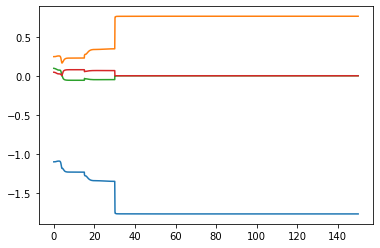

In [20]:
for row in range(len(theta_arr)):
    plt.plot(t, theta_arr[row,:])
plt.show()

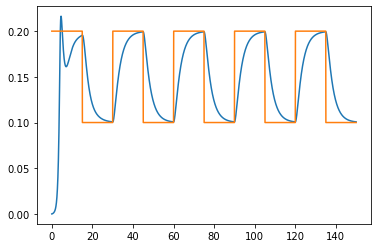

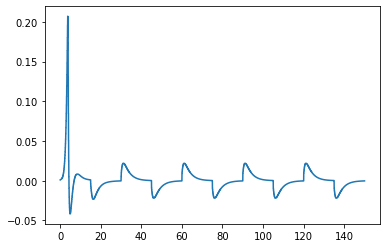

In [21]:
et = len(t)
plt.plot(t[0:et], y_measure[0:et])
plt.plot(t[0:et], uc_val[0:et])
plt.show()
plt.step(t[0:et], u_val[0:et])
plt.show()

In [33]:
pulse_coeffs = A[0][0][1:].tolist()
for Bi in B[0][0]:
    pulse_coeffs.append(Bi)
pulse_coeffs

[-1.768453904085495,
 0.768453904085495,
 0.0048339652400897215,
 0.004427878596490631]

In [25]:
B, A = co.tfdata(co.sample_system(co.tf([b_nom], [1, b_nom, 0]), method='zoh', Ts=Ts_val))